### This script ensures, that all machines, measurements and years data have the correct naming.

In [ ]:
#Script 1: a general “bulk renamer” for all machines in dataset/.
#It standardizes machine-folder prefixes, simplifies measurement-folder names, and fixes file names that include the old measurement name.

import os
import re
from pathlib import Path

# Mapping of location prefixes
LOCATION_MAP = {
    "AVT": "EPI",
    "TH": "TEC",
    "PVPlant": "EPI_PV"
}

DATASET_DIR = Path("dataset")

def rename_machine_name(old_name):
    if old_name.startswith("PVPlant"):
        return LOCATION_MAP["PVPlant"]

    match = re.match(r"([A-Z]+)(\d{2})_(.+)", old_name)
    if not match:
        print(f"[!] Skipping unrecognized machine name: {old_name}")
        return old_name

    prefix, num, name = match.groups()
    new_prefix = LOCATION_MAP.get(prefix, prefix)
    return f"{new_prefix}_{name}"

def rename_measurement_folder(old_name):
    match = re.match(r"\d{3}_(.+)", old_name)
    return match.group(1) if match else old_name

def rename_files_in_folder(folder, old_meas_name, new_meas_name):
    for file in folder.glob("*.csv.xz"):
        pattern = rf"(\d{{4}})_{old_meas_name}\.csv\.xz"
        match = re.match(pattern, file.name)
        if match:
            year = match.group(1)
            new_name = f"{year}_{new_meas_name}.csv.xz"
            file.rename(file.parent / new_name)
            print(f"    [file] {file.name} → {new_name}")

def rename_machine_folder_inplace(machine_path):
    machine_name = machine_path.name
    new_machine_name = rename_machine_name(machine_name)
    target_machine_path = machine_path.parent / new_machine_name

    # Rename measurements and files first
    for child in machine_path.iterdir():
        if not child.is_dir() or child.name == "000_metadata":
            continue

        old_meas_name = child.name
        new_meas_name = rename_measurement_folder(old_meas_name)

        if old_meas_name != new_meas_name:
            target_meas_path = machine_path / new_meas_name
            child.rename(target_meas_path)
            print(f"  [meas] {old_meas_name} → {new_meas_name}")
        else:
            target_meas_path = child

        rename_files_in_folder(target_meas_path, old_meas_name, new_meas_name)

    # Now rename the machine folder
    if machine_path != target_machine_path:
        machine_path.rename(target_machine_path)
        print(f"[✓] Renamed machine folder: {machine_name} → {target_machine_path.name}\n")

def main():
    for machine_path in DATASET_DIR.iterdir():
        if not machine_path.is_dir():
            continue
        # Skip if already renamed
        if machine_path.name.startswith(("EPI_", "TEC_", "IPE_PV")):
            continue
        if "_" in machine_path.name:
            rename_machine_folder_inplace(machine_path)

if __name__ == "__main__":
    main()


In [ ]:
import os
import re
from pathlib import Path

PV_DIR = Path("dataset/EPI_PV")
YEAR = "2024"

def rename_pv_measurements():
    if not PV_DIR.exists():
        print(f"[!] Folder not found: {PV_DIR}")
        return

    for meas_folder in PV_DIR.iterdir():
        if not meas_folder.is_dir():
            continue
        if meas_folder.name == "000_metadata":
            continue

        files = list(meas_folder.glob("EnMaSy_*.csv.xz"))
        if not files:
            print(f"[!] No matching files in: {meas_folder}")
            continue

        file = files[0]
        match = re.match(r"EnMaSy_\d{3}_(.+)\.csv\.xz", file.name)
        if not match:
            print(f"[!] Unexpected file format: {file.name}")
            continue

        meas_name = match.group(1)

        # Rename file
        new_file_name = f"{YEAR}_{meas_name}.csv.xz"
        new_file_path = file.parent / new_file_name
        file.rename(new_file_path)
        print(f"  [✓] Renamed file: {file.name} → {new_file_name}")

        # Rename folder
        new_folder_path = PV_DIR / meas_name
        if meas_folder != new_folder_path:
            meas_folder.rename(new_folder_path)
            print(f"[✓] Renamed folder: {meas_folder.name} → {meas_name}")

def main():
    rename_pv_measurements()

if __name__ == "__main__":
    main()


### Correct consistant voltage abbreviation U1 (not V1) and percentages
- Change Directory, File name, Column name, if % change from Unit 0.1% to %.

In [35]:
import pandas as pd
df = pd.read_csv(f"../dataset_clean/EPI_PickAndPlace/THD_V1/2018_THD_V1.csv.xz")
display(df.head(2))

df = pd.read_csv(f"../dataset_clean/EPI_PickAndPlace/THD_V1/2018_THD_V1.csv.xz.bak")
display(df.head(2))

,WsDateTime,THD_V1
0,2018-01-01 00:00:00,3.5
1,2018-01-01 00:00:05,3.5


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfd in position 0: invalid start byte

,WsDateTime,V1_h9
0,2024-01-01 00:00:00,NaN
1,2024-01-01 00:00:05,NaN


<Axes: >

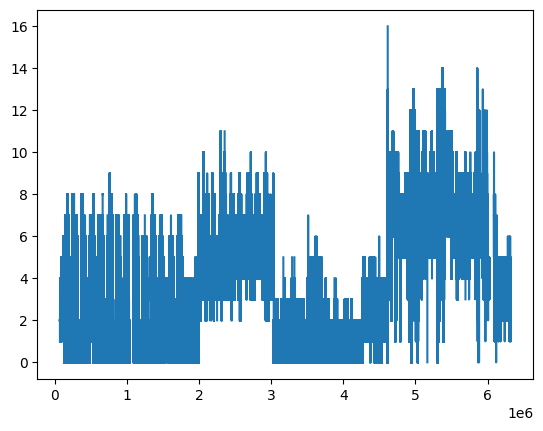

In [17]:
import pandas as pd #EPI_VacuumPump2/V1_h9/2022_V1_h9.csv.xz
df = pd.read_csv(f"../dataset_clean/EPI_ScreenPrinter/V1_h9/2024_V1_h9.csv.xz")
display(df.head(2))
df["V1_h9"].plot()

In [1]:
from __future__ import annotations
from pathlib import Path
import re
import pandas as pd
from typing import Dict, List

# ========= Configuration =========
# Machines whose percent-like values are stored as "0.10%" and must be scaled to "%" by ×0.1.
MACHINES_WITH_PERCENT_FIX = {"EPI_PickAndPlace", "EPI_ScreenPrinter", "EPI_VacuumPump2"}
# V-notation measurement directories (need rename to U-notation)
V_DIR_REGEX = re.compile(r"^(V[123].*|.*_V[123].*)$")
# Current THD/harmonic directories (scale only, no rename)
# Examples: THD_I1, THD_IN, I1_h17, IN_h3, etc.
CURRENT_PCT_DIR_REGEX = re.compile(r"^(THD_(I[123]|IN)|(I[123]|IN)_h\d+)$")
# Filenames are always "YYYY_<measurement>.csv.xz"
FILENAME_REGEX = re.compile(r"^(\d{4})_(.+)\.csv\.xz$")
# Columns considered "percent-like" (need ×0.1 on selected machines): THD_* and *_hNN
PERCENT_COLUMN_PATTERNS = [re.compile(r"^THD_"), re.compile(r".*_h\d+$")]
# Optional numeric prefix at the start of a column name, e.g. "083_"
# We must preserve it and operate on the "core" (suffix) part only.
PREFIX_REGEX = re.compile(r"^(?P<prefix>\d+_)(?P<core>.+)$")

# ========= Helpers (prefix-aware) =========
def split_prefix(name: str) -> tuple[str, str]:
    """
    Split a column name into (prefix, core).
    Example: "083_V1_h9" -> ("083_", "V1_h9"); "THD_I1" -> ("", "THD_I1")
    """
    m = PREFIX_REGEX.match(name)
    if m:
        return m.group("prefix"), m.group("core")
    return "", name

def join_prefix(prefix: str, core: str) -> str:
    """Reassemble prefix + core."""
    return f"{prefix}{core}"

def convert_v_to_u_core(core: str) -> str:
    """
    Convert V… → U… in the *core* only (not touching any numeric prefix).
      "V1" -> "U1", "V1_h11" -> "U1_h11", "THD_V1" -> "THD_U1"
    """
    core = re.sub(r"^V", "U", core)
    core = re.sub(r"_V([123])", r"_U\1", core)
    return core

def convert_v_to_u_full(name: str) -> str:
    """
    Convert V… → U… while preserving any leading numeric prefix.
      "083_V1_h9" -> "083_U1_h9"
    """
    prefix, core = split_prefix(name)
    return join_prefix(prefix, convert_v_to_u_core(core))

def is_percent_like_core(core: str) -> bool:
    """Percent-like if THD_* or *_hNN (timestamp excluded)."""
    if core == "WsDateTime":
        return False
    return any(p.match(core) for p in PERCENT_COLUMN_PATTERNS)

def is_percent_like_column(full_name: str) -> bool:
    """
    Percent-like detection that ignores an optional numeric prefix.
    Example: "083_U1_h9" -> check "U1_h9"
    """
    prefix, core = split_prefix(full_name)
    return is_percent_like_core(core)

def read_header_columns(csv_path: Path) -> List[str]:
    """Read only the header; fall back to a conservative guess if it fails."""
    try:
        df = pd.read_csv(csv_path, nrows=0, compression="xz", low_memory=False)
        return list(df.columns)
    except Exception:
        # Most files are single-signal besides WsDateTime; caller may substitute directory name.
        return ["WsDateTime"]

def sample_before_after_values(
    csv_path: Path,
    old_to_new_cols: Dict[str, str],
    percent_cols_after_rename: List[str],
    max_samples: int = 1,
) -> List[str]:
    """
    Return compact 'col old→new' samples for a few values that will change.
    Works with prefixed columns; shows values after ×0.1 (if applicable).
    - Reads a small chunk (first ~200 rows) and picks non-null values.
    """
    if not percent_cols_after_rename:
        return []

    # Build reverse map: new -> old (identity if not renamed)
    new_to_old = {new: old for old, new in old_to_new_cols.items()}
    for col in percent_cols_after_rename:
        new_to_old.setdefault(col, col)

    # Minimal read: just the old columns we need (no need for WsDateTime)
    needed_old_cols = sorted(set([new_to_old[c] for c in percent_cols_after_rename]))
    try:
        df = pd.read_csv(csv_path, compression="xz",usecols=needed_old_cols, nrows=200, low_memory=False)
    except Exception:
        return []

    samples: List[str] = []
    for new_col in percent_cols_after_rename:
        old_col = new_to_old.get(new_col, new_col)
        if old_col not in df.columns:
            continue
        series = pd.to_numeric(df[old_col], errors="coerce").dropna()
        for val in series.head(max_samples):
            try:
                before = float(val)
                after = before * 0.1
                # Format to avoid scientific notation, up to 6 sig figs
                samples.append(f"{new_col} {before:.6g}→{after:.6g}")
            except Exception:
                continue
        if len(samples) >= max_samples:
            break

    return samples

# ========= Main =========
def plan_and_apply(
    root: str | Path,
    perform: bool = False,
    backup_root: str | Path | None = None,
) -> List[Dict]:
    """
    Dry-run by default. Prints ONE concise line per affected file:
      OLD -> NEW | old_cols:[...] -> new_cols:[...] | samples:[col before→after,...] | backup:<path>
    - Rename + (maybe) scale: V-notation dirs (V1, V1_h11, THD_V1, …) → U-notation; percent cols ×0.1 on selected machines.
    - Scale only: current THD/harmonics dirs (THD_I1, THD_IN, I1_hNN, IN_hNN) on selected machines (no rename).
    - All files assumed to be '.csv.xz'.
    - When perform=True:
        * Original moved to <backup_root>/<relative path>
        * Corrected written to NEW path
    Returns a plan list with details per file.
    """
    root = Path(root).resolve()
    if not root.exists():
        raise FileNotFoundError(root)

    backup_root_path = Path(backup_root).resolve() if backup_root else (root / "_backup_VtoU")
    plans: List[Dict] = []
    n_rename = 0
    n_adjust = 0
    any_hit = False

    # Walk all measurement directories: <root>/<MACHINE>/<MEASUREMENT>/
    for meas_dir in (p for p in root.rglob("*") if p.is_dir()):
        rel = meas_dir.relative_to(root)
        if len(rel.parts) < 2:
            continue
        machine, measurement_dir_name = rel.parts[:2]

        # Decide which mode applies to this directory
        is_v_dir = bool(V_DIR_REGEX.match(measurement_dir_name))
        is_current_pct_dir = (machine in MACHINES_WITH_PERCENT_FIX) and bool(CURRENT_PCT_DIR_REGEX.match(measurement_dir_name))
        if not is_v_dir and not is_current_pct_dir:
            continue

        # Target measurement name (rename only for V-dirs)
        target_measurement_dir_name = convert_v_to_u_core(measurement_dir_name) if is_v_dir else measurement_dir_name

        for csv_path in meas_dir.glob("*.csv.xz"):
            m = FILENAME_REGEX.match(csv_path.name)
            if not m:
                continue
            year, meas_in_file = m.groups()

            # Build new filename/path (rename only for V-dirs)
            target_meas_in_file = convert_v_to_u_core(meas_in_file) if is_v_dir else meas_in_file
            new_basename = f"{year}_{target_meas_in_file}.csv.xz"
            new_dir = root / machine / target_measurement_dir_name
            new_path = new_dir / new_basename

            # Read header and prepare column rename map (prefix-aware)
            old_cols = read_header_columns(csv_path)
            if old_cols == ["WsDateTime"]:
                # Fallback: assume single-signal column equals directory's measurement name
                # (no prefix available in this fallback scenario)
                old_cols = ["WsDateTime", measurement_dir_name]

            col_rename_map: Dict[str, str] = {}
            for c in old_cols:
                if c == "WsDateTime":
                    continue
                prefix, core = split_prefix(c)
                new_core = convert_v_to_u_core(core) if is_v_dir else core
                new_c = join_prefix(prefix, new_core)
                if new_c != c:
                    col_rename_map[c] = new_c

            new_cols = [col_rename_map.get(c, c) for c in old_cols]

            # Percent scaling applies only on selected machines; detect AFTER rename (prefix-aware)
            do_percent_fix = (machine in MACHINES_WITH_PERCENT_FIX)
            percent_cols_after_rename = [c for c in new_cols if do_percent_fix and is_percent_like_column(c)]

            will_rename = is_v_dir and (
                (target_measurement_dir_name != measurement_dir_name)
                or (new_basename != csv_path.name)
                or bool(col_rename_map)
            )
            will_adjust = bool(percent_cols_after_rename)
            n_rename += int(will_rename)
            n_adjust += int(will_adjust)
            any_hit = True

            # Show a few value samples that would change (before→after), prefix-aware
            samples = sample_before_after_values(
                csv_path=csv_path,
                old_to_new_cols={**{c: c for c in old_cols}, **col_rename_map},  # include identity for non-renamed
                percent_cols_after_rename=percent_cols_after_rename,
                max_samples=1,
            )

            old_rel = f"{machine}/{measurement_dir_name}/{csv_path.name}"
            new_rel = f"{machine}/{target_measurement_dir_name}/{new_basename}"
            backup_target = backup_root_path / csv_path.relative_to(root)

            # ONE LINE per file (compact & complete)
            print(
                f"{old_rel} -> {new_rel} | "
                f"old_cols:[{', '.join(old_cols)}] -> new_cols:[{', '.join(new_cols)}] | "
                f"samples:[{'; '.join(samples) or '-'}] | "
                f"backup:{backup_target}"
            )

            plans.append({
                "machine": machine,
                "old_path": str(csv_path),
                "new_path": str(new_path),
                "old_columns": old_cols,
                "new_columns": new_cols,
                "column_renames": col_rename_map,
                "percent_columns_scaled_x0_1": percent_cols_after_rename,
                "will_rename": will_rename,
                "will_adjust": will_adjust,
                "backup_target": str(backup_target),
            })

            if perform:
                # Read full data
                df = pd.read_csv(csv_path, compression="xz", low_memory=False)

                # Apply V→U renames (prefix-aware)
                if col_rename_map:
                    df.rename(columns=col_rename_map, inplace=True)

                # Apply percent scaling ×0.1 (only for selected machines; prefix-aware detection)
                if percent_cols_after_rename:
                    for col in percent_cols_after_rename:
                        if col in df.columns:
                            df[col] = pd.to_numeric(df[col], errors="coerce") * 0.1

                # Ensure output dir exists
                new_dir.mkdir(parents=True, exist_ok=True)

                # Move original to backup (preserve relative structure)
                backup_target.parent.mkdir(parents=True, exist_ok=True)
                csv_path.replace(backup_target)

                # Write corrected file
                df.to_csv(new_path, index=False, compression="xz")

    if not any_hit:
        print("(no matching measurement directories found)")

    print(f"SUMMARY | rename:{n_rename} adjust:{n_adjust} | backup_root:{backup_root_path}")
    return plans

# --- Example ---
#plans = plan_and_apply("../dataset_clean", perform=False)
plans = plan_and_apply("../dataset_clean", perform=True)


EPI_PickAndPlace/I1_h11/2018_I1_h11.csv.xz -> EPI_PickAndPlace/I1_h11/2018_I1_h11.csv.xz | old_cols:[WsDateTime, I1_h11] -> new_cols:[WsDateTime, I1_h11] | samples:[I1_h11 61→6.1] | backup:D:\EnergyDataset\dataset_clean\_backup_VtoU\EPI_PickAndPlace\I1_h11\2018_I1_h11.csv.xz
EPI_PickAndPlace/I1_h11/2019_I1_h11.csv.xz -> EPI_PickAndPlace/I1_h11/2019_I1_h11.csv.xz | old_cols:[WsDateTime, I1_h11] -> new_cols:[WsDateTime, I1_h11] | samples:[-] | backup:D:\EnergyDataset\dataset_clean\_backup_VtoU\EPI_PickAndPlace\I1_h11\2019_I1_h11.csv.xz
EPI_PickAndPlace/I1_h11/2020_I1_h11.csv.xz -> EPI_PickAndPlace/I1_h11/2020_I1_h11.csv.xz | old_cols:[WsDateTime, I1_h11] -> new_cols:[WsDateTime, I1_h11] | samples:[-] | backup:D:\EnergyDataset\dataset_clean\_backup_VtoU\EPI_PickAndPlace\I1_h11\2020_I1_h11.csv.xz
EPI_PickAndPlace/I1_h11/2021_I1_h11.csv.xz -> EPI_PickAndPlace/I1_h11/2021_I1_h11.csv.xz | old_cols:[WsDateTime, I1_h11] -> new_cols:[WsDateTime, I1_h11] | samples:[I1_h11 100→10] | backup:D:\Ener

In [ ]:
from __future__ import annotations
from pathlib import Path
import re
import pandas as pd
from typing import Dict, List

# ================== Configuration ==================

# Only these machines are processed (both rename and scaling logic apply only here)
MACHINES_WITH_PERCENT_FIX = {"EPI_PickAndPlace", "EPI_ScreenPrinter", "EPI_VacuumPump2"}

# dataset_clean_validation contains derived CSVs we want to correct
VALIDATION_FILE_GLOB_STATS   = "*_stats.csv"
VALIDATION_FILE_GLOB_MISSING = "*_missing.csv"

# Measurement directory patterns
V_DIR_REGEX        = re.compile(r"^(V[123].*|.*_V[123].*)$")  # needs V→U rename
PERCENT_MEAS_REGEX = re.compile(r"^(THD_.*|.*_h\d+)$")        # percent-like measurements

# Filenames: YYYY_<measurement>_stats.csv / _missing.csv
FNAME_STATS_REGEX   = re.compile(r"^(\d{4})_(.+)_stats\.csv$")
FNAME_MISSING_REGEX = re.compile(r"^(\d{4})_(.+)_missing\.csv$")

# ================== V→U helpers (path- and name-safe) ==================
def convert_v_to_u_measure_name(name: str) -> str:
    """Convert a measurement name from V… to U… (e.g., V1_h3→U1_h3, THD_V1→THD_U1)."""
    name = re.sub(r"^V", "U", name)
    name = re.sub(r"_V([123])", r"_U\1", name)
    return name

def convert_v_to_u_path_string(path_str: str) -> str:
    """
    Convert V→U in a path string without look-behinds.
    Works for both '\' and '/' separators; preserves other parts of the path.
    """
    parts = re.split(r'([\\/])', path_str)  # keep separators

    for i in range(0, len(parts), 2):  # components at even indexes
        comp = parts[i]
        if not comp:
            continue
        if comp in ("V1", "V2", "V3"):
            parts[i] = "U" + comp[1]
            continue
        comp = re.sub(r'(^|_)V([123])(?=(_|$))', lambda m: f"{m.group(1)}U{m.group(2)}", comp)
        comp = re.sub(r'_V([123])', r'_U\1', comp)
        parts[i] = comp

    return ''.join(parts)

def is_percent_measure(measurement: str) -> bool:
    """True if measurement name is THD_* or *_hNN."""
    return bool(PERCENT_MEAS_REGEX.match(measurement))

def numeric_columns(df: pd.DataFrame, exclude: List[str]) -> List[str]:
    """All numeric columns except those explicitly excluded."""
    return [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

# ================== Core ==================
def process_dataset_clean_validation(root: str | Path,
                                     perform: bool = False,
                                     backup_root: str | Path | None = None) -> List[Dict]:
    """
    Process ONLY machines in MACHINES_WITH_PERCENT_FIX.
      - *_stats.csv: scale numerics ×0.1 for percent-like measurements; V→U rename; fix file_path column.
      - *_missing.csv: V→U rename; fix file_path column (no scaling).
    Prints exactly one concise line per file that actually changes:
      OLD -> NEW | actions:[rename;scale;fpfix] | scaled_cols:[...] | file_path_in_csv: OLD→NEW | backup:<path>
    """
    root = Path(root).resolve()
    if not root.exists():
        raise FileNotFoundError(root)
    backup_root_path = Path(backup_root).resolve() if backup_root else (root / "_backup_VtoU_validation")

    plans: List[Dict] = []
    n_stats_scaled = n_stats_renamed = n_missing_renamed = 0
    any_hit = False

    def handle_validation_csv(csv_path: Path, is_stats: bool) -> None:
        nonlocal n_stats_scaled, n_stats_renamed, n_missing_renamed, any_hit

        rel = csv_path.relative_to(root)
        if len(rel.parts) < 3:
            return
        machine, measurement_dir, filename = rel.parts[0], rel.parts[1], rel.name

        # Only process selected machines
        if machine not in MACHINES_WITH_PERCENT_FIX:
            return

        # Parse filename: (year, measurement_in_filename)
        m = (FNAME_STATS_REGEX if is_stats else FNAME_MISSING_REGEX).match(filename)
        if not m:
            return
        year, meas_in_file = m.groups()

        # Determine rename targets (V→U) if needed
        is_v_dir = bool(V_DIR_REGEX.match(measurement_dir))
        target_measurement_dir  = convert_v_to_u_measure_name(measurement_dir) if is_v_dir else measurement_dir
        target_meas_in_filename = convert_v_to_u_measure_name(meas_in_file)    if is_v_dir else meas_in_file
        new_basename = f"{year}_{target_meas_in_filename}_{'stats' if is_stats else 'missing'}.csv"
        new_dir  = root / machine / target_measurement_dir
        new_path = new_dir / new_basename

        # Read CSV
        try:
            df = pd.read_csv(csv_path, low_memory=False)
        except Exception as e:
            print(f"[WARN] Failed to read: {csv_path} ({e})")
            return

        # Fix file_path column (if present): V→U in raw-data pointer
        old_fp = None
        new_fp = None
        did_fp_fix = False
        if "file_path" in df.columns and len(df) > 0 and isinstance(df["file_path"].iloc[0], str):
            old_fp = df["file_path"].iloc[0]
            new_fp = convert_v_to_u_path_string(old_fp)
            if old_fp != new_fp:
                df.loc[:, "file_path"] = df["file_path"].astype(str).map(convert_v_to_u_path_string)
                did_fp_fix = True

        # Decide scaling (only for stats + percent-like measurements)
        will_scale = False
        scaled_cols: List[str] = []
        if is_stats and is_percent_measure(target_measurement_dir):
            num_cols = numeric_columns(df, exclude=["file_path"])
            if num_cols:
                will_scale = True
                scaled_cols = num_cols

        # Decide rename (only if V→U would change dir and/or filename)
        will_rename = is_v_dir and ((target_measurement_dir != measurement_dir) or (new_path.name != filename))

        # If nothing to do, skip entirely (no print, no plan, no changes)
        if not (will_rename or will_scale or did_fp_fix):
            return

        any_hit = True
        if will_rename:
            if is_stats:
                n_stats_renamed += 1
            else:
                n_missing_renamed += 1
        if will_scale:
            n_stats_scaled += 1

        # Apply transformations in perform mode
        if perform:
            if will_scale:
                df[scaled_cols] = df[scaled_cols].apply(pd.to_numeric, errors="coerce") * 0.1
            # Ensure output dir exists
            (new_dir if will_rename else csv_path.parent).mkdir(parents=True, exist_ok=True)
            # Move original to backup
            backup_target = backup_root_path / rel
            backup_target.parent.mkdir(parents=True, exist_ok=True)
            csv_path.replace(backup_target)
            # Write corrected file (renamed path if needed)
            out_path = new_path if will_rename else (root / rel)
            df.to_csv(out_path, index=False)

        # Compose concise one-liner
        actions = []
        if will_rename: actions.append("rename")
        if will_scale:  actions.append("scale")
        if did_fp_fix:  actions.append("fpfix")
        old_rel = str(rel).replace("\\", "/")
        new_rel = (str(new_path.relative_to(root)).replace("\\", "/") if will_rename else old_rel)
        scaled_cols_txt = (", ".join(scaled_cols) if will_scale else "-")
        fp_change_txt = f"{old_fp or '-'}→{new_fp or (old_fp or '-')}"
        backup_txt = (backup_root_path / rel).as_posix()

        print(f"{old_rel} -> {new_rel} | actions:[{';'.join(actions)}] | "
              f"scaled_cols:[{scaled_cols_txt}] | file_path_in_csv: {fp_change_txt} | backup:{backup_txt}")

        plans.append({
            "type": "stats" if is_stats else "missing",
            "machine": machine,
            "old_path": str(csv_path),
            "new_path": str(new_path if will_rename else csv_path),
            "measurement_old": measurement_dir,
            "measurement_new": target_measurement_dir,
            "scaled_columns": scaled_cols,
            "file_path_in_csv_old": old_fp,
            "file_path_in_csv_new": new_fp if did_fp_fix else old_fp,
            "will_rename": will_rename,
            "will_scale": will_scale,
            "did_file_path_fix": did_fp_fix,
            "backup_target": str(backup_root_path / rel),
        })

    # Process only files that belong to the selected machines
    for stats_path in root.rglob(VALIDATION_FILE_GLOB_STATS):
        # fast check the machine folder if possible (…/<machine>/<measurement>/file)
        parts = stats_path.parts
        if len(parts) >= 3 and parts[-3] in MACHINES_WITH_PERCENT_FIX:
            handle_validation_csv(stats_path, is_stats=True)

    for miss_path in root.rglob(VALIDATION_FILE_GLOB_MISSING):
        parts = miss_path.parts
        if len(parts) >= 3 and parts[-3] in MACHINES_WITH_PERCENT_FIX:
            handle_validation_csv(miss_path, is_stats=False)

    if not any_hit:
        print("(no files required changes under the selected machines)")

    print(f"SUMMARY | stats_scaled:{n_stats_scaled} stats_renamed:{n_stats_renamed} "
          f"missing_renamed:{n_missing_renamed} | backup_root:{backup_root_path.as_posix()}")
    return plans

# --- Example usage ---
#plans = process_dataset_clean_validation("../dataset_clean_validation", perform=False)
#plans = process_dataset_clean_validation("../dataset_clean_validation", perform=True)


EPI_PickAndPlace/Freq/2018_Freq_stats.csv -> EPI_PickAndPlace/Freq/2018_Freq_stats.csv | scaled_cols:[-] | file_path_in_csv: dataset_clean\EPI_PickAndPlace\Freq\2018_Freq.csv.xz→dataset_clean\EPI_PickAndPlace\Freq\2018_Freq.csv.xz | backup:D:/EnergyDataset/dataset_clean_validation/_backup_VtoU_validation/EPI_PickAndPlace/Freq/2018_Freq_stats.csv
EPI_PickAndPlace/Freq/2019_Freq_stats.csv -> EPI_PickAndPlace/Freq/2019_Freq_stats.csv | scaled_cols:[-] | file_path_in_csv: dataset_clean\EPI_PickAndPlace\Freq\2019_Freq.csv.xz→dataset_clean\EPI_PickAndPlace\Freq\2019_Freq.csv.xz | backup:D:/EnergyDataset/dataset_clean_validation/_backup_VtoU_validation/EPI_PickAndPlace/Freq/2019_Freq_stats.csv
EPI_PickAndPlace/Freq/2020_Freq_stats.csv -> EPI_PickAndPlace/Freq/2020_Freq_stats.csv | scaled_cols:[-] | file_path_in_csv: dataset_clean\EPI_PickAndPlace\Freq\2020_Freq.csv.xz→dataset_clean\EPI_PickAndPlace\Freq\2020_Freq.csv.xz | backup:D:/EnergyDataset/dataset_clean_validation/_backup_VtoU_validatio